<a href="https://colab.research.google.com/github/melodiw82/FoodClassification_DL/blob/main/FoodClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

# Downloading The Dataset

In [95]:
# import gdown

# file_id = '15CHt2ueS4c7emHpmzFHC3c0TGd51Mnvz'
# output_file = '/content/train.zip'


# gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)

In [96]:
# import zipfile

# zip_file_path = '/content/train.zip'
# extract_dir = '/content/Data/'

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# Creating The DataFrame

In [97]:
train_dir = '/content/Data/train'

In [98]:
categories = sorted(os.listdir(train_dir))
categories

['baked_potato',
 'baklava',
 'caesar_salad',
 'cheese_sandwich',
 'cheesecake',
 'chicken',
 'chicken_curry',
 'chocolate_cake',
 'donuts',
 'eggs',
 'falafel',
 'fish',
 'french_fries',
 'hamburger',
 'hot_dog',
 'ice_cream',
 'lasagna',
 'omelette',
 'pizza',
 'spaghetti',
 'steak',
 'sushi']

In [99]:
df = pd.DataFrame(columns=['image_path', 'label'])
df

,image_path,label


In [100]:
dfs = []

for category in categories:
    category_path = os.path.join(train_dir, category)
    image_data = []
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_data.append({'image_path': image_path, 'label': category})
    df_category = pd.DataFrame(image_data)
    dfs.append(df_category)

In [101]:
df = pd.concat(dfs, ignore_index=True)
df

,image_path,label
0,/content/Data/train/baked_potato/5d86df9a-97d.jpg,baked_potato
1,/content/Data/train/baked_potato/f7b19975-db0.jpg,baked_potato
2,/content/Data/train/baked_potato/6434a4c2-3c1.jpg,baked_potato
3,/content/Data/train/baked_potato/331f2203-1c1.jpg,baked_potato
4,/content/Data/train/baked_potato/fa9cb987-f5e.jpg,baked_potato
...,...,...
24084,/content/Data/train/sushi/c2d87ece-b99.jpg,sushi
24085,/content/Data/train/sushi/f04bbf17-208.jpg,sushi
24086,/content/Data/train/sushi/d2d64464-b10.jpg,sushi
24087,/content/Data/train/sushi/e9206463-77f.jpg,sushi


In [102]:
df['label'].value_counts()

donuts             2395
hamburger          2376
chicken            2293
french_fries       2286
spaghetti          1509
baked_potato       1501
hot_dog            1057
pizza               887
omelette            715
caesar_salad        709
falafel             709
fish                708
cheese_sandwich     708
chicken_curry       707
ice_cream           705
chocolate_cake      702
eggs                699
lasagna             693
sushi               690
steak               681
baklava             680
cheesecake          679
Name: label, dtype: int64

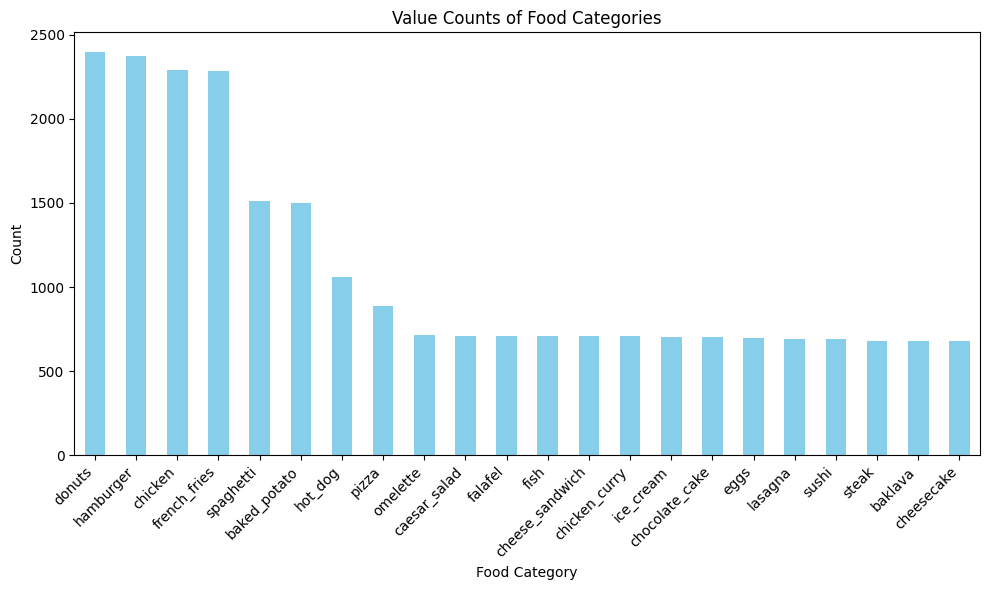

In [103]:
plt.figure(figsize=(10, 6))

df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Food Category')
plt.ylabel('Count')
plt.title('Value Counts of Food Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The dataset shows class imbalance, where some food categories have many more samples than others. For example, "donuts" and "hamburger" have lots of samples, while "steak" or "cheesecake" have much fewer.

### Computing class weights

In [104]:
labels = df['label']

In [105]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

In [106]:
class_weight_dict = dict(zip(np.unique(labels), class_weights))

In [107]:
print("Class Weights:", class_weight_dict)

Class Weights: {'baked_potato': 0.7294833747198837, 'baklava': 1.6102272727272726, 'caesar_salad': 1.5443646621361713, 'cheese_sandwich': 1.5465459681561375, 'cheesecake': 1.612598741464721, 'chicken': 0.47752051698846293, 'chicken_curry': 1.5487334447730488, 'chocolate_cake': 1.5597643097643097, 'donuts': 0.45718352628582276, 'eggs': 1.566458577188191, 'falafel': 1.5443646621361713, 'fish': 1.5465459681561375, 'french_fries': 0.4789827407937644, 'hamburger': 0.46083945515763697, 'hot_dog': 1.035907800808463, 'ice_cream': 1.5531270148291425, 'lasagna': 1.5800209891118981, 'omelette': 1.531404958677686, 'pizza': 1.2344470636466127, 'spaghetti': 0.7256160009639135, 'steak': 1.60786276865572, 'sushi': 1.5868906455862977}


# Train_Test Split

In [108]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [109]:
train_df.shape

(19271, 2)

In [110]:
val_df.shape

(4818, 2)

# Image Augmentation

In [111]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [112]:
val_datagen = ImageDataGenerator(
    rescale = 1./255
    )

In [113]:
img_size = (224, 224)

In [114]:
batch_size = 32

In [115]:
train_images = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',

    target_size=img_size,
    batch_size=batch_size,

    shuffle=True,
    seed=42,
    class_mode='categorical'
)

Found 19271 validated image filenames belonging to 22 classes.


In [116]:
val_images = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',

    target_size=img_size,
    batch_size=batch_size,

    shuffle=False,
    seed=42,
    class_mode='categorical'
)

Found 4818 validated image filenames belonging to 22 classes.


# Visualize Some Images From Different Categories

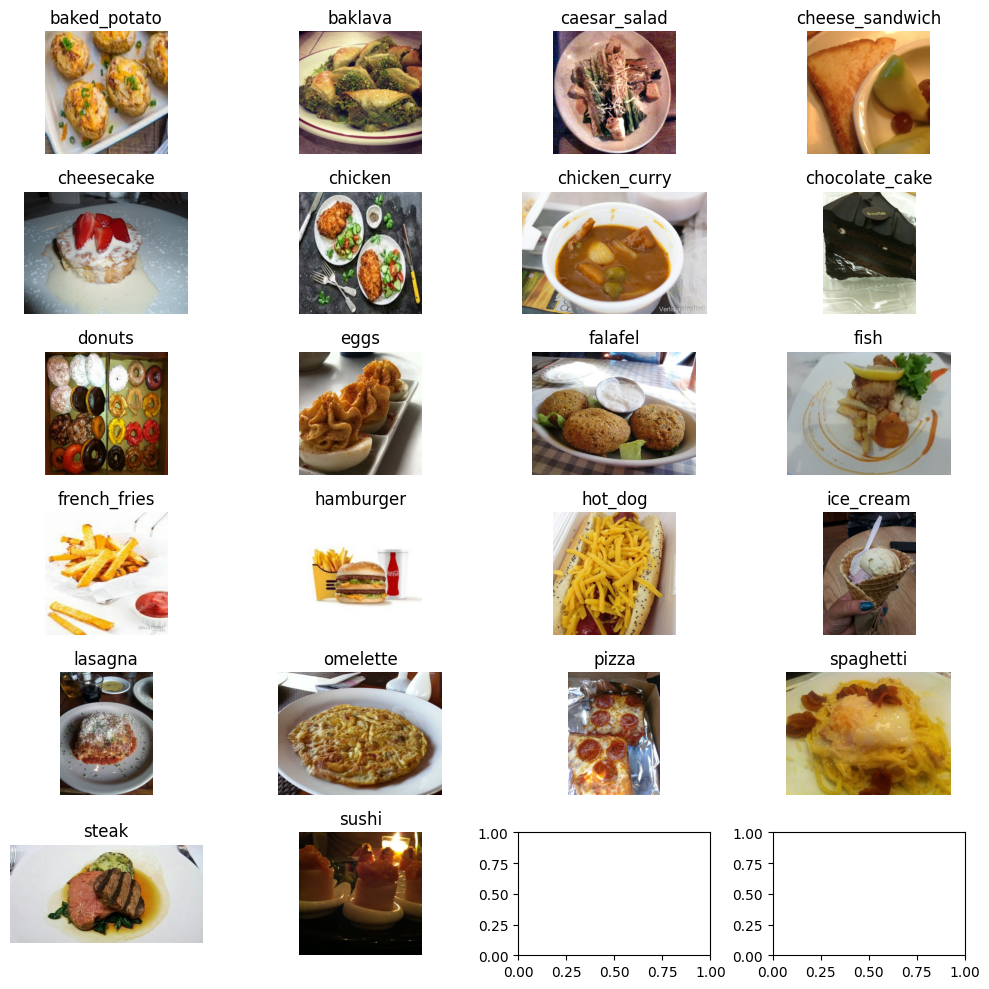

In [117]:
fig, axes = plt.subplots(6, 4, figsize=(10, 10))
axes = axes.flatten()

for i, category in enumerate(categories):
    category_df = train_df[train_df['label'] == category]
    image_path = category_df.iloc[100]['image_path']
    img = plt.imread(image_path)
    axes[i].imshow(img)
    axes[i].set_title(category)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

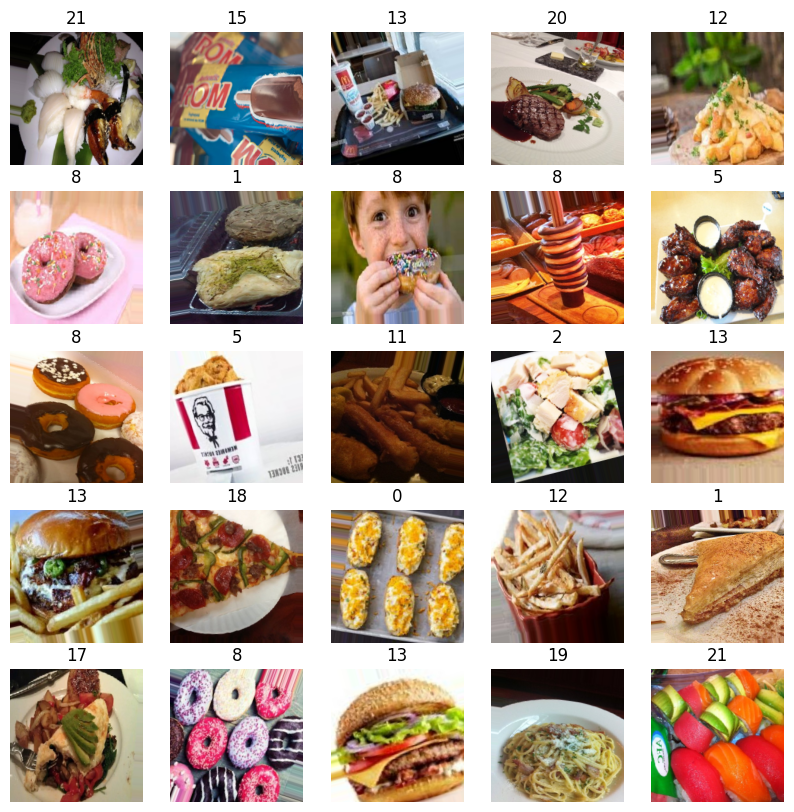

In [118]:
batch_train_images, batch_train_labels = next(train_images)

class_names = np.argmax(batch_train_labels, axis=1)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(batch_train_images[i])
    plt.title(class_names[i])
    plt.axis('off')
plt.show()